In [1]:
import numpy as np
import h5py
import glob, os, re, sys

from PRFMData import PRFMDataset
import astro_helper as ah

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')
custom_colors = {
    'grey': '#3C3C3C',
    'turquoise': '#5E9F87'
}

In [2]:
ETG_vlM = PRFMDataset(
    galaxy_type="ETG-vlM",
    total_height=0.3, # kpc
    Rmax=2., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [3]:
ETG_lowM = PRFMDataset(
    galaxy_type="ETG-lowM",
    total_height=0.3, # kpc
    Rmax=2., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [4]:
ETG_medM = PRFMDataset(
    galaxy_type="ETG-medM",
    total_height=0.3, # kpc
    Rmax=2., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [5]:
ETG_hiM = PRFMDataset(
    galaxy_type="ETG-hiM",
    total_height=0.3, # kpc
    Rmax=2., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [6]:
NGC300 = PRFMDataset(
    galaxy_type="NGC300",
    total_height=1.5, # kpc
    Rmax=6., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_799.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [7]:
MW = PRFMDataset(
    galaxy_type="MW",
    total_height=1.5, # kpc
    Rmax=6., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_600.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

# calculate the integrand of the ISM weight for each case, to check if it's symmetrical

In [8]:
from scipy.signal import savgol_filter as sg
polyno=2
wndwlen=5

In [10]:
data = [ETG_vlM, ETG_lowM, ETG_medM, ETG_hiM, NGC300, MW]
zbin_centers = [instance.zbin_centers_ptl for instance in data]

In [12]:
integrands = []
for instance in data:
    rho = instance.get_gas_density_Rphiz(zbinsep=instance.zbin_sep_ptl)
    ptl = instance.get_potential_Rphiz()

    dz = sg(instance.zbin_centers_3d_ptl, wndwlen, polyno, deriv=1, axis=2)
    dPhi = sg(ptl, wndwlen, polyno, deriv=1, axis=2)
    dPhidz = dPhi/dz

    integrand = rho * dPhidz * instance.zbin_sep_ptl
    integrands.append(integrand)
    print("finished one")

finished one
finished one
finished one
finished one
finished one
finished one


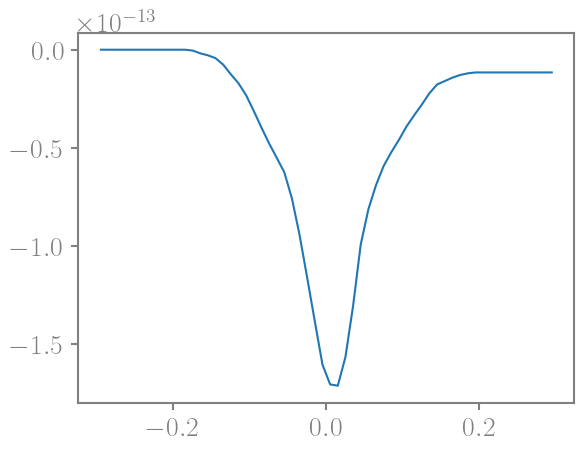

In [36]:
for zbins, integrand in zip(zbin_centers, integrands):
    plt.plot(zbins/ah.kpc_to_cm, np.cumsum(np.median(integrand, axis=(0,1))))
plt.show()

# check the extent of non-zero potentials and densities along the z-axis, to make sure we've captured everything

In [6]:
ptls, denses = [], []
for instance in data:
    ptl = instance.get_potential_Rphiz()
    dens = instance.get_gas_density_Rphiz()
    ptls.append(ptl)
    denses.append(dens)

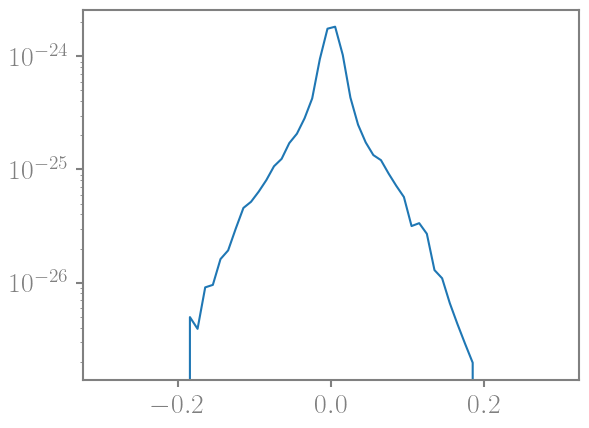

In [23]:
for zbins, dens in zip(zbin_centers, denses):
    plt.plot(zbins, dens)
plt.yscale('log')
plt.show()

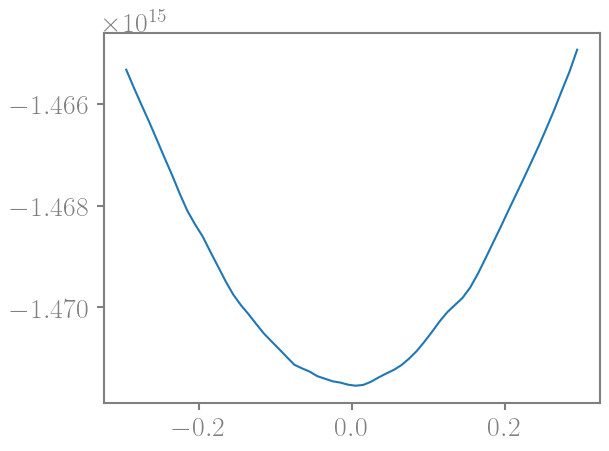

In [24]:
for zbins, ptl in zip(zbin_centers, ptls):
    plt.plot(zbins, ptl)
plt.yscale('log')
plt.show()